# Statistical inference of stock returns with linear regression
#### Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

import pandas as pd

from statsmodels.api import OLS, add_constant, graphics
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import norm

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

### Load Data

In [10]:

with pd.HDFStore('../data/data.h5') as store:
    data = (store['model_data']
            .dropna()
            .drop(['open', 'close', 'low', 'high'], axis=1))

volume     dollar_vol  dollar_vol_1m  dollar_vol_rank  \
ticker date                                                                  
A      2013-07-03  1940.600   58048.109098  101337.664640            283.0   
       2013-07-05  2097.800   64291.124508  100743.415368            276.0   
       2013-07-08  2570.100   78997.174965   98907.017589            279.0   
       2013-07-09  3476.200  107426.052047   99890.447470            277.0   
       2013-07-10  3277.600  102901.099374  100771.458984            275.0   
...                     ...            ...            ...              ...   
ZUMZ   2017-11-22   265.795    4943.787000    5761.835586           1545.0   
       2017-11-24   208.610    3974.020500    5720.920719           1536.0   
       2017-11-27   443.388    8513.049600    5915.601226           1518.0   
       2017-11-28   689.911   13867.211100    6376.928660           1491.0   
       2017-11-29   724.964   15115.499400    6934.407026           1470.0   

                         rsi   bb_high    bb_low       atr      macd  \
ticker date                                                            
A      2013-07-03  47.022639  0.047226  0.033655 -0.742189 -0.935638   
       2013-07-05  54.500180  0.022396  0.054860 -0.676938 -0.781327   
       2013-07-08  55.332862  0.016871  0.056179 -0.811799 -0.642010   
       2013-07-09  56.901016  0.011608  0.060952 -0.913233 -0.503858   
       2013-07-10  61.236660  0.000519  0.076786 -0.830665 -0.316199   
...                      ...       ...       ...       ...       ...   
ZUMZ   2017-11-22  55.097028  0.038098  0.084078 -0.811466  0.561643   
       2017-11-24  58.668474  0.020911  0.104159 -0.743366  0.580630   
       2017-11-27  59.815803  0.018437  0.111935 -0.572586  0.605366   
       2017-11-28  65.927314 -0.010605  0.151383 -0.449853  0.716139   
       2017-11-29  70.019337 -0.025148  0.181312 -0.371734  0.876695   

                   return_1d  ...  consumer_durables  consumer_non-durables  \
ticker date                   ...                                             
A      2013-07-03   0.001857  ...                  0                      0   
       2013-07-05   0.024554  ...                  0                      0   
       2013-07-08   0.002939  ...                  0                      0   
       2013-07-09   0.005410  ...                  0                      0   
       2013-07-10   0.015919  ...                  0                      0   
...                      ...  ...                ...                    ...   
ZUMZ   2017-11-22  -0.038760  ...                  0                      0   
       2017-11-24   0.024194  ...                  0                      0   
       2017-11-27   0.007874  ...                  0                      0   
       2017-11-28   0.046875  ...                  0                      0   
       2017-11-29   0.037313  ...                  0                      0   

                   consumer_services  energy  finance  health_care  \
ticker date                                                          
A      2013-07-03                  0       0        0            0   
       2013-07-05                  0       0        0            0   
       2013-07-08                  0       0        0            0   
       2013-07-09                  0       0        0            0   
       2013-07-10                  0       0        0            0   
...                              ...     ...      ...          ...   
ZUMZ   2017-11-22                  1       0        0            0   
       2017-11-24                  1       0        0            0   
       2017-11-27                  1       0        0            0   
       2017-11-28                  1       0        0            0   
       2017-11-29                  1       0        0            0   

                   miscellaneous  public_utilities  technology  transportation  
ticker date                                      

### Select Investment Universe

In [12]:
data = data[data.dollar_vol_rank<100]

In [13]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 109675 entries, ('AAL', Timestamp('2013-07-25 00:00:00')) to ('ZTS', Timestamp('2014-12-04 00:00:00'))
Data columns (total 65 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   volume                 109675 non-null  float64
 1   dollar_vol             109675 non-null  float64
 2   dollar_vol_1m          109675 non-null  float64
 3   dollar_vol_rank        109675 non-null  float64
 4   rsi                    109675 non-null  float64
 5   bb_high                109675 non-null  float64
 6   bb_low                 109675 non-null  float64
 7   atr                    109675 non-null  float64
 8   macd                   109675 non-null  float64
 9   return_1d              109675 non-null  float64
 10  return_5d              109675 non-null  float64
 11  return_10d             109675 non-null  float64
 12  return_21d             109675 non-null  float64
 13  return_42d    

### Create Model Data

In [18]:
y = data.filter(like='target')
X = data.drop(y.columns, axis=1)
X = X.drop(['dollar_vol', 'dollar_vol_rank', 'volume', 'consumer_durables'], axis=1)

### Explore Data

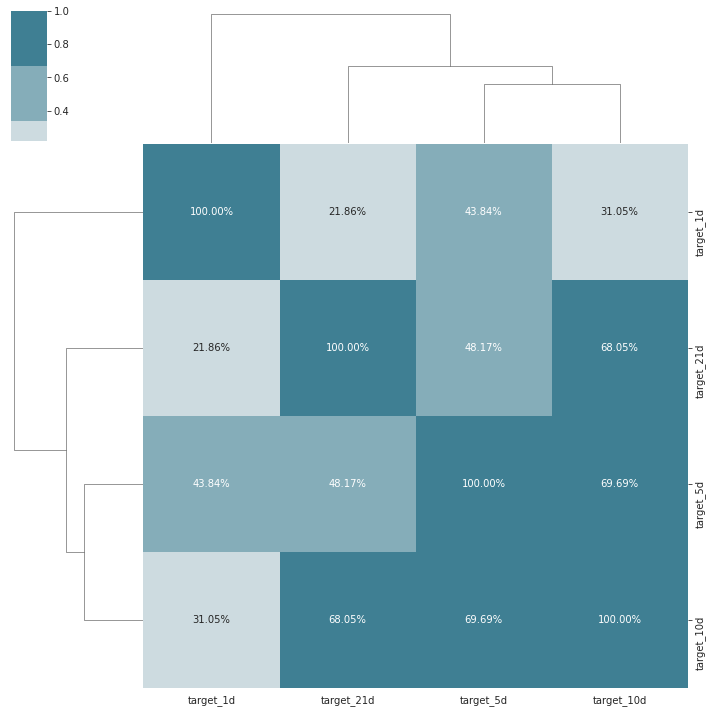

In [21]:
sns.clustermap(y.corr(), cmap=sns.diverging_palette(h_neg=20, h_pos=220), center=0, annot=True, fmt='.2%')

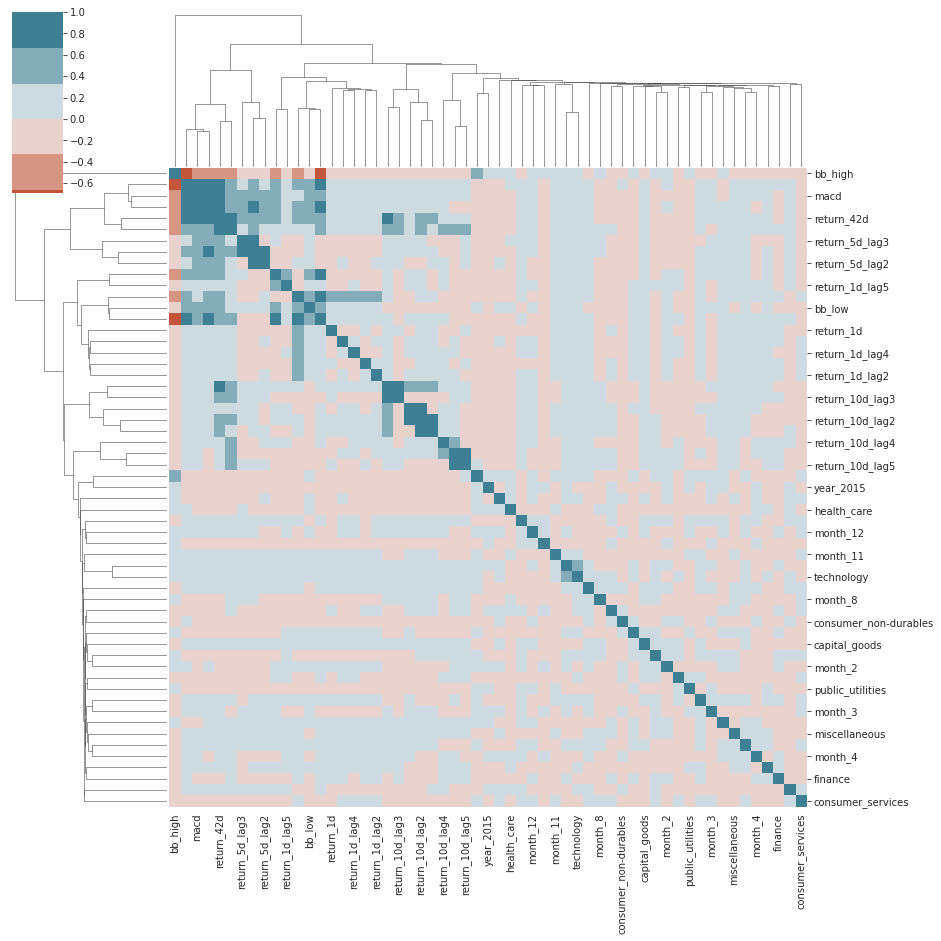

In [22]:
sns.clustermap(X.corr(), cmap=sns.diverging_palette(h_neg=20, h_pos=220), center=0);
plt.gcf().set_size_inches((14, 14))

In [31]:
corr_mat = X.corr().stack().reset_index()
corr_mat.columns = ['var1', 'var_2', 'corr']
corr_mat = corr_mat[corr_mat.var1 != corr_mat.var_2].sort_values(by='corr', ascending=False)

In [35]:
corr_mat.head().append(corr_mat.tail())

,var1,var_2,corr
581,return_42d,return_63d,0.835634
637,return_63d,return_42d,0.835634
286,macd,rsi,0.817113
62,rsi,macd,0.817113
518,return_21d,macd,0.793893
515,return_21d,bb_high,-0.632777
122,bb_high,return_10d,-0.693640
458,return_10d,bb_high,-0.693640
59,rsi,bb_high,-0.696555
115,bb_high,rsi,-0.696555


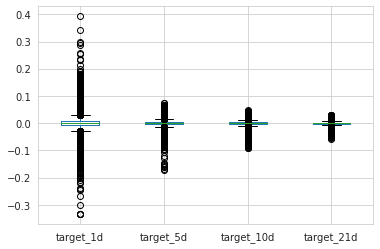

In [38]:
y.boxplot();

### Linear Regression

In [44]:
sectors = X.iloc[:, -10:]
X = (X.drop(sectors.columns, axis=1)
     .groupby(level='ticker')
     .transform(lambda x: (x - x.mean()) / x.std())
     .join(sectors)
     .fillna(0))

### 1-Day Returns

In [50]:
target = 'target_1d'
model = OLS(endog=y[target], exog=add_constant(X))
trained_model = model.fit()
print(trained_model.summary())

                            OLS Regression Results                            
Dep. Variable:              target_1d   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     19.03
Date:                Wed, 15 Jun 2022   Prob (F-statistic):          9.43e-189
Time:                        08:25:25   Log-Likelihood:             2.8852e+05
No. Observations:              109675   AIC:                        -5.769e+05
Df Residuals:                  109617   BIC:                        -5.764e+05
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.00

### 5-Day Returns

In [51]:
target = 'target_5d'
model = OLS(endog=y[target], exog=add_constant(X))
trained_model = model.fit()
print(trained_model.summary())

                            OLS Regression Results                            
Dep. Variable:              target_5d   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     61.86
Date:                Wed, 15 Jun 2022   Prob (F-statistic):               0.00
Time:                        08:26:07   Log-Likelihood:             3.7883e+05
No. Observations:              109675   AIC:                        -7.575e+05
Df Residuals:                  109617   BIC:                        -7.570e+05
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.00

### Obtain the residuals

In [52]:
preds = trained_model.predict(add_constant(X))
residuals = y[target] - preds

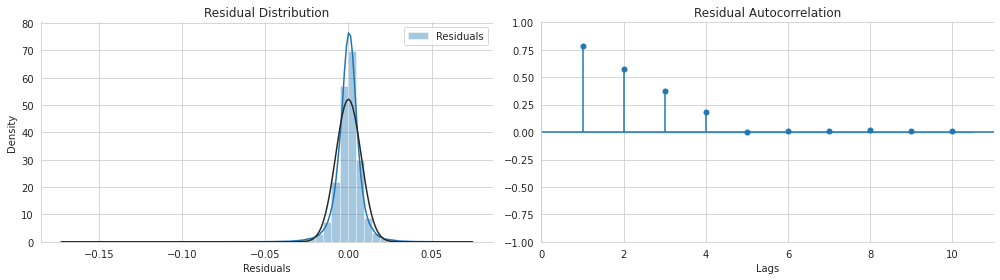

In [58]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 4))
sns.distplot(residuals, fit=norm, ax=axes[0], axlabel='Residuals', label='Residuals')
axes[0].set_title('Residual Distribution')
axes[0].legend()
plot_acf(residuals, lags=10, ax=axes[1], zero=False, title='Residual Autocorrelation')
axes[1].set_xlabel('Lags')
sns.despine()
fig.tight_layout();

### 10-Day Returns

In [57]:
target = 'target_10d'
model = OLS(endog=y[target], exog=add_constant(X))
trained_model = model.fit()
print(trained_model.summary())

                            OLS Regression Results                            
Dep. Variable:             target_10d   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     85.38
Date:                Wed, 15 Jun 2022   Prob (F-statistic):               0.00
Time:                        08:29:32   Log-Likelihood:             4.1892e+05
No. Observations:              109675   AIC:                        -8.377e+05
Df Residuals:                  109617   BIC:                        -8.372e+05
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.00